In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline
from statsmodels.stats.proportion import proportions_ztest

from sklearn.metrics import auc
import xgboost as xgb


from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
fdf = pd.read_csv('/content/drive/MyDrive/criteo-uplift-v2.1.csv')

In [ ]:
df = fdf

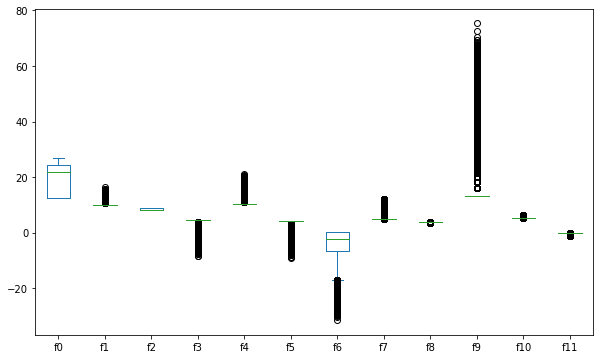

In [ ]:
df.drop(['treatment','conversion','visit','exposure'], axis = 1).plot.box(figsize=(10,6))

<ipython-input-6-c2e43169b01e>:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


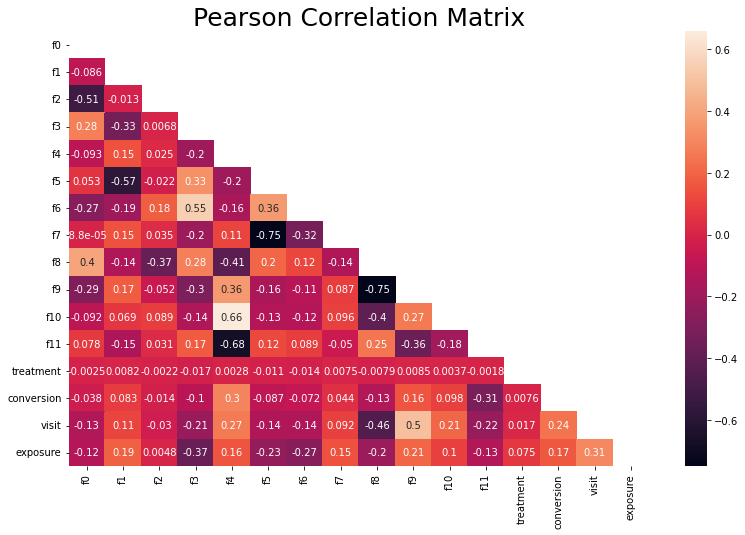

In [ ]:
f, ax = plt.subplots(figsize=(13, 8))
plt.title('Pearson Correlation Matrix',fontsize=25)

corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

sns.heatmap(corr, annot=True, mask = mask)

1    0.85
0    0.15
Name: treatment, dtype: float64


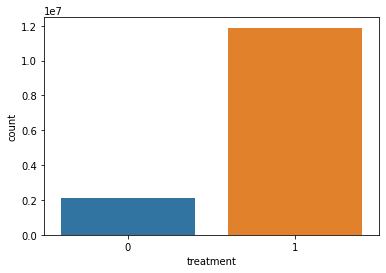

In [ ]:
sns.countplot(x='treatment', data=df)
print(df['treatment'].value_counts(normalize = True))

0    0.969369
1    0.030631
Name: exposure, dtype: float64


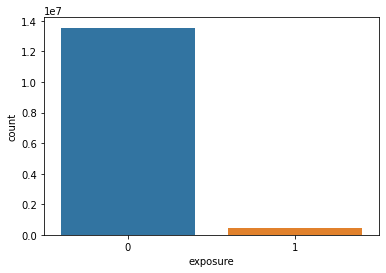

In [ ]:
sns.countplot(x='exposure', data=df)
print(df['exposure'].value_counts(normalize = True))

0    0.997083
1    0.002917
Name: conversion, dtype: float64


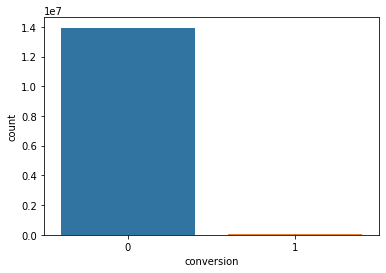

In [ ]:
sns.countplot(x='conversion', data=df)
print(df['conversion'].value_counts(normalize = True))

0    0.953008
1    0.046992
Name: visit, dtype: float64


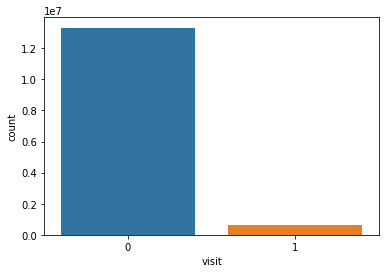

In [ ]:
sns.countplot(x='visit', data=df)
print(df['visit'].value_counts(normalize = True))

In [ ]:
table_conv = df.groupby(['treatment','exposure']).agg({'conversion':['mean','sum','count']})
print(table_conv)

                   conversion                 
                         mean    sum     count
treatment exposure                            
0         0          0.001938   4063   2096937
1         0          0.001194  13680  11454443
          1          0.053784  23031    428212


In [ ]:
table_vis = df.groupby(['treatment','exposure']).agg({'visit':['mean','sum','count']})
print(table_vis)

                       visit                  
                        mean     sum     count
treatment exposure                            
0         0         0.038201   80105   2096937
1         0         0.034861  399314  11454443
          1         0.414538  177510    428212


In [ ]:
df.groupby(['treatment','exposure','visit']).agg({'conversion':['mean','sum','count']})

conversion                 
                               mean    sum     count
treatment exposure visit                            
0         0        0       0.000000      0   2016832
                   1       0.050721   4063     80105
1         0        0       0.000000      0  11055129
                   1       0.034259  13680    399314
          1        0       0.000000      0    250702
                   1       0.129745  23031    177510

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

proportions_ztest(count=table_conv.reset_index()[('conversion')]['sum'].loc[:1],
                  nobs=table_conv.reset_index()[('conversion')]['count'].loc[:1])[1]

6.983951422749621e-165

In [ ]:
proportions_ztest(count=table_conv.reset_index()[('conversion')]['sum'].drop(1),
                  nobs=table_conv.reset_index()[('conversion')]['count'].drop(1))[1]

0.0

In [ ]:
proportions_ztest(count=table_vis.reset_index()[('visit')]['sum'].loc[:1],
                  nobs=table_vis.reset_index()[('visit')]['count'].loc[:1])[1]

5.150161571101964e-128

In [ ]:
proportions_ztest(count=table_vis.reset_index()[('visit')]['sum'].drop(1),
                  nobs=table_vis.reset_index()[('visit')]['count'].drop(1))[1]

0.0

In [ ]:
users_to_remove = df[(df['treatment'] == 1 ) & (df['exposure']==0)]

#New df based on the objective of the notebook
df_ml = df.drop(users_to_remove.index).reset_index().drop(['index','treatment', 'visit'], axis = 1)

In [ ]:
len(users_to_remove)

11454443

0    2096937
1     428212
Name: exposure, dtype: int64
Normalized:
0    0.830421
1    0.169579
Name: exposure, dtype: float64


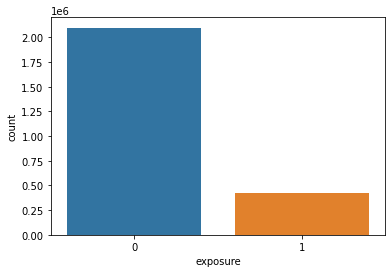

In [ ]:
sns.countplot(x='exposure', data=df_ml)
print(df_ml['exposure'].value_counts())
print("Normalized:")
print(df_ml['exposure'].value_counts(normalize = True))

Users converted given no exposure
0    2092874
1       4063
Name: conversion, dtype: int64
Users converted given exposure
0    405181
1     23031
Name: conversion, dtype: int64


Text(0.5, 1.0, 'Conversion given exposure')

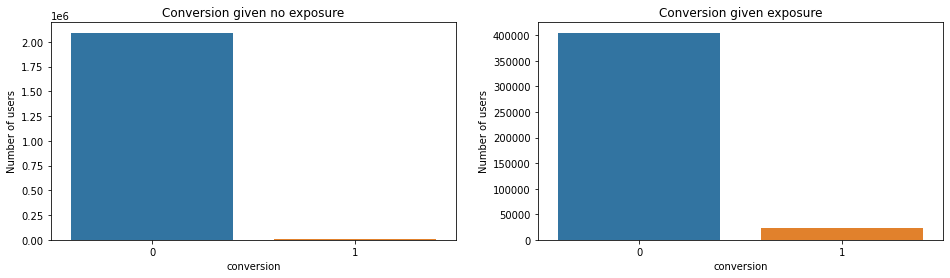

In [ ]:
df_noexp = df_ml[df_ml['exposure'] == 0]
df_exp = df_ml[df_ml['exposure'] == 1]

print("Users converted given no exposure")
print(df_noexp['conversion'].value_counts())

print("Users converted given exposure")
print(df_exp['conversion'].value_counts())

#Plot both graphs
fig, ax = plt.subplots( ncols=2, figsize = (16,4))

sns.countplot(x='conversion', data=df_noexp, ax=ax[0])
ax[0].set_ylabel('Number of users')
ax[0].set_title('Conversion given no exposure')

sns.countplot(x='conversion', data=df_exp, ax=ax[1])
ax[1].set_ylabel('Number of users')
ax[1].set_title('Conversion given exposure')

In [ ]:
from sklearn import preprocessing

scaled = preprocessing.scale(df_ml.drop(['conversion','exposure'], axis = 1).values)
df_sca = pd.DataFrame(data=scaled, columns = df_ml.drop(['conversion','exposure'], axis = 1).columns)
df_exposure = df_ml['exposure']
df_conversion = df_ml['conversion']

In [ ]:
from sklearn.model_selection import train_test_split

stratify_cols = pd.concat([df_exposure, df_conversion], axis=1)

#Setting up testing and traning sets
X_train, X_test, trmnt_train , trmnt_test, y_train, y_test = train_test_split(df_sca,
                                                                             df_exposure,
                                                                             df_conversion,
                                                                             stratify = stratify_cols,
                                                                             test_size = 0.1,
                                                                             random_state=42)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (2272634, 12)
Test shape: (252515, 12)


In [ ]:
y_traincml = y_train[trmnt_train==1]
X_traincml = X_train[trmnt_train==1]

0    364663
1     20728
Name: conversion, dtype: int64
Normalized:
0    0.946216
1    0.053784
Name: conversion, dtype: float64


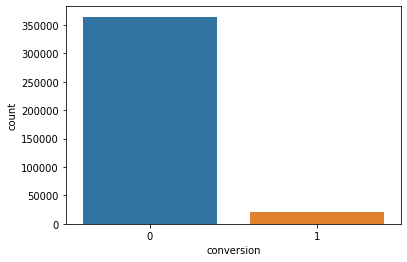

In [ ]:
sns.countplot(x='conversion', data=y_traincml.to_frame())
print(y_traincml.value_counts())
print("Normalized:")
print(y_traincml.value_counts(normalize = True))

In [ ]:
#Setting up testing and training sets
X_train_cml, X_val_cml, y_train_cml, y_val_cml = train_test_split(X_traincml,y_traincml, test_size=0.3, random_state=42)

print('Train instances: {}, None_Conversion: {} and Conversion: {}'.format(len(y_train_cml),
                                                                         y_train_cml.value_counts()[0],
                                                                         y_train_cml.value_counts()[1]))

print('Val instances: {}, None_Conversion: {} and Conversion: {}'.format( len(y_val_cml), 
                                                                         y_val_cml.value_counts()[0],
                                                                         y_val_cml.value_counts()[1]))


Train instances: 269773, None_Conversion: 255282 and Conversion: 14491
Val instances: 115618, None_Conversion: 109381 and Conversion: 6237


In [ ]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42 )
X_train_sm, y_train_sm = sm.fit_resample(X_train_cml, y_train_cml)

print(y_train_sm.value_counts())

0    255282
1    255282
Name: conversion, dtype: int64


In [ ]:
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression

In [ ]:
dummy = DummyClassifier(strategy='uniform', random_state=42).fit(X_train_sm, y_train_sm)
dummy_pred = dummy.predict(X_val_cml.values)

print("Precision: ", precision_score(y_val_cml, dummy_pred))
print("Recall: ", recall_score(y_val_cml, dummy_pred))

Precision:  0.054207510699986194
Recall:  0.5036075036075036


In [ ]:
logreg_sm = LogisticRegression().fit(X_train_sm.values, y_train_sm.values)
logreg_sm_pred = logreg_sm.predict(X_val_cml.values)

print("Precision: ", precision_score(y_val_cml, logreg_sm_pred))
print("Recall: ", recall_score(y_val_cml, logreg_sm_pred))

Precision:  0.19507329343394916
Recall:  0.7211800545133878


In [ ]:
xgb_sm = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'aucpr',  use_label_encoder = False).fit(X_train_sm.values,
                                                                                      y_train_sm.values)
xgb_sm_pred = xgb_sm.predict(X_val_cml.values)

print("Precision: ", precision_score(y_val_cml, xgb_sm_pred))
print("Recall: ", recall_score(y_val_cml, xgb_sm_pred))


Precision:  0.21465864452289793
Recall:  0.6921596921596922


In [ ]:
values = {'tp':49, 'fp':1, 'fn':49}

def value_eq(values, conf_matrix): 
    """
    Function that computes the value generated by the model
    
    Parameters:
    -----------
    values: dict with the values of the outcomes
    conf_matrix: confusion matrix of the models
    """
    tp = conf_matrix[1,1]
    fp = conf_matrix[0,1]
    fn = conf_matrix[1,0]
    
    return tp*values['tp'] - fp*values['fp'] - fn*values['fn']

In [ ]:
cm_rand_sm = confusion_matrix(y_val_cml, dummy_pred)

#Confusion Matrix of Logistic Regression
cm_logreg_sm = confusion_matrix(y_val_cml, logreg_sm_pred)

#Confusion Matrix of XGB
cm_xgb_sm = confusion_matrix(y_val_cml, xgb_sm_pred)

#Print the benefit from both models
print(f'The profit in USD with the Random model is $ {value_eq(values,cm_rand_sm):,.2f}')
print(f'The profit in USD with the Logistic Regression model is $ {value_eq(values,cm_logreg_sm):,.2f}')
print(f'The profit in USD with XGBoost model is $ {value_eq(values,cm_xgb_sm):,.2f}')

The profit in USD with the Random model is $ -52,598.00
The profit in USD with the Logistic Regression model is $ 116,631.00
The profit in USD with XGBoost model is $ 101,659.00


In [ ]:
def outcome_value(y_pred,y_test,values):
    """
    Returns the value of the outcome
    
    Parameters:
    -----------
    y_pred: classes estimated by the classifier
    y_test: actual classes
    value: value of the outcome
    """
    if y_pred == 1 and y_test == 1:
        return values['tp']
    if y_pred == 1 and y_test==0:
        return -values['fp']
    elif y_pred== 0 and y_test==1:
        return -values['fn']
    else:
        return 0
    
def compute_value_df(y_proba,y_test,values, best_thres= 0.5):
    """
    Generates a df with the cummulative cost of the errors
    
    Parameters:
    ------------
    y_proba: array with the probabilities of X_test given by an estimator
    y_test: array with the actual values of y
    best_thres: int best threshold to define a binary outcome
    values: dict with the value of the outcomes
    """
    #Build the df for the cost curve
    df_value_curve = pd.DataFrame({'y_proba':y_proba, 
                                         'y_pred': np.where(y_proba > best_thres,1,0),
                                         'y_test':y_test})

    #Sort df by probability
    df_value_curve = df_value_curve.sort_values(by='y_proba'
                                                            , ascending = False).reset_index().drop('index', axis =1)

    #Compute the value of each outcome
    df_value_curve['value'] = df_value_curve.apply(lambda x: outcome_value(x.y_pred, x.y_test,values), axis=1)

    #Compute the cummulative sum of the outcomes
    df_value_curve['cum_value'] = df_value_curve['value'].cumsum(axis=0)
    
    return df_value_curve

In [ ]:
#random model 
dummy_proba = dummy.predict_proba(X_val_cml.values)[:,1]
df_dummy_val_curve = compute_value_df(dummy_proba,y_val_cml,values)

#Get the probabilities for each instance based on the estimator
logreg_y_proba = logreg_sm.predict_proba(X_val_cml.values)[:,1]
df_logreg_val_curve = compute_value_df(logreg_y_proba,y_val_cml,values)

#Get the probabilities for each instance based on the estimator
xgb_y_proba = xgb_sm.predict_proba(X_val_cml.values)[:,1]
df_xgboost_val_curve = compute_value_df(xgb_y_proba,y_val_cml,values)

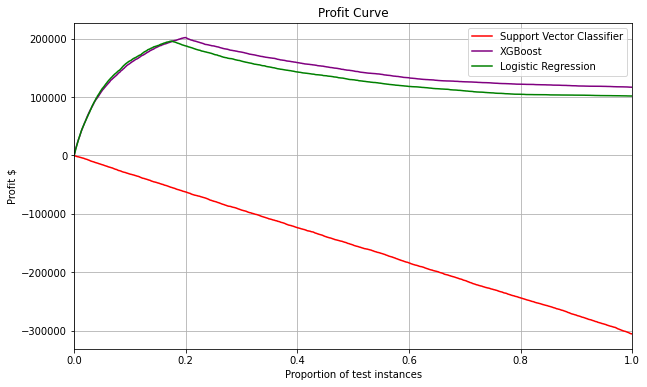

In [ ]:
_, axes = plt.subplots(figsize=(10, 6))

instances=np.arange(0, 1, (1/len(y_val_cml)))

axes.set_title("Profit Curve")
axes.set_xlabel("Proportion of test instances")
axes.set_ylabel("Profit $")
axes.grid(b=True)

axes.plot(instances, df_dummy_val_curve['cum_value'].values, '-', color="red",label="Support Vector Classifier")
axes.plot(instances, df_logreg_val_curve['cum_value'].values, '-', color="purple",label="XGBoost")
axes.plot(instances, df_xgboost_val_curve['cum_value'].values, '-', color="green",label="Logistic Regression")

axes.legend(loc="best")
axes.set_xlim(0,1)
#axes.set_ylim(0,1)
plt.show()

In [ ]:
stratify_cols = pd.concat([trmnt_train, y_train], axis=1)

#Setting up testing and traning sets
X_trainup, X_valup, trmnt_trainup , trmnt_valup , y_trainup , y_valup = train_test_split(X_train,
                                                                                         trmnt_train,
                                                                                         y_train,
                                                                                         stratify = stratify_cols,
                                                                                         test_size = 0.3,
                                                                                         random_state=42)

print(f"Train shape: {X_trainup.shape}")
print(f"Validation shape: {X_valup.shape}")

Train shape: (1590843, 12)
Validation shape: (681791, 12)


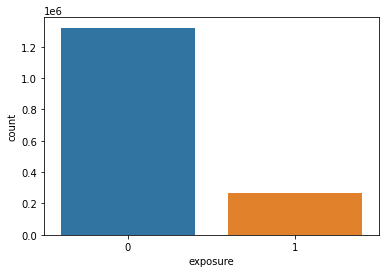

In [ ]:
#Imbalanced in the treatment variableo
sns.countplot(x='exposure', data=trmnt_trainup.to_frame())

In [ ]:
tmp = X_trainup.copy()
tmp.insert(len(tmp.columns)-1, 'conversion', y_trainup.values)
tmp.insert(len(tmp.columns)-1, 'exposure', trmnt_trainup.values)

#separte df based on the treatment
tmp1 = tmp[tmp['exposure']==1]
tmp2 = tmp[tmp['exposure']==0]

#Subsampling
tmp2 = tmp2.sample(n=len(tmp1))
tmp3 = pd.concat([tmp1,tmp2], axis=0)

#Updating the variables
X_trainup_sub = tmp3.drop(['exposure','conversion'], axis = 1)
trmnt_trainup_sub = tmp3['exposure']
y_trainup_sub = tmp3['conversion']

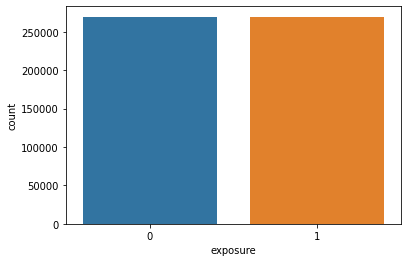

In [ ]:
#Checking the umbalance
sns.countplot(x='exposure', data=trmnt_trainup_sub.to_frame())

In [ ]:
!pip install scikit-uplift

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 KB 2.6 MB/s eta 0:00:00


In [ ]:
from sklift.models import SoloModel, TwoModels

estimator = LogisticRegression()

#Single Model
sm = SoloModel(estimator)
sm = sm.fit(X_trainup_sub, y_trainup_sub, trmnt_trainup_sub)
uplift_sm = sm.predict(X_valup)

#Two Independent models
tm = TwoModels(estimator_trmnt= LogisticRegression(), estimator_ctrl= LogisticRegression(), method='vanilla')
tm = tm.fit(X_trainup_sub, y_trainup_sub, trmnt_trainup_sub)
uplift_tm = tm.predict(X_valup)

In [ ]:
def get_tc(treatment,target):
    """
    Function that returns helps to select the users that were in the control group and have a positive response
    
    Parameters:
    ------------
    treatment = treatment
    target = the response 
    """    
    if not target:
        return 0
    elif not treatment:
        return 1
    else:
        return 0
    
def compute_gain(df_x, uplift, treatment, y, rnd = False):
    """
    Function that computes the cumulative gains in a dataframe
    
    Parameters:
    ------------
    uplift = arr with the predicted uplifts by the models
    trtment = arr with the treatment indicator (test)
    y = arr target variable (test)
    rnd = bool indicating if random selection
    """
    e = 0.0000000000001 # to avoid divisions by zero
    base = pd.DataFrame({'uplift':uplift, 'treatment':treatment.values, 'target': y.values})

    df = pd.concat([df_x,base], axis = 1)
    
    #sort based on the flag
    if rnd:
        df = df.sample(frac=1).reset_index().drop('index', axis =1)
    else:
        df = df.sort_values(by='uplift', ascending = False).reset_index().drop('index', axis =1)
    
    #Compute the cumulative treatment size
    df['cum_trs'] = df['treatment'].cumsum(axis=0)

    #Compute the cumulative control size
    df['cum_crs'] = (df.index+1) - df['treatment'].cumsum(axis=0)
    
    #Compute target given treatment
    df['ttr'] = df['treatment'] * df['target']
    
    #Compute target given control
    df['tcr'] = df.apply(lambda x: get_tc(x.treatment, x.target), axis=1)
    
    #Compute cumulative target given treatment
    df['cum_ttr'] = df['ttr'].cumsum(axis=0)
    
    #Compute cumulative target given control
    df['cum_tcr'] = df['tcr'].cumsum(axis=0)
    
    #Compute cumulative gain from one to uplift [descent]
    df['cum_gain'] = (df['cum_ttr']/(df['cum_trs']+e)) - (df['cum_tcr']/(df['cum_crs']+e))
    
    #Compute cumulative gain from zero to uplift [ascending]
    df['cum_gain2'] = df['cum_gain']*(df['cum_trs']+df['cum_crs']+e)/ len(df)
    
    return df   

In [ ]:
df_x_valup = X_valup.reset_index().drop('index',axis=1)

#Compute gain for the three models
sm_gain = compute_gain(df_x_valup, uplift_sm,trmnt_valup, y_valup)
tm_gain = compute_gain(df_x_valup, uplift_tm,trmnt_valup, y_valup)
rnd_gain = compute_gain(df_x_valup, uplift_tm,trmnt_valup, y_valup, True)

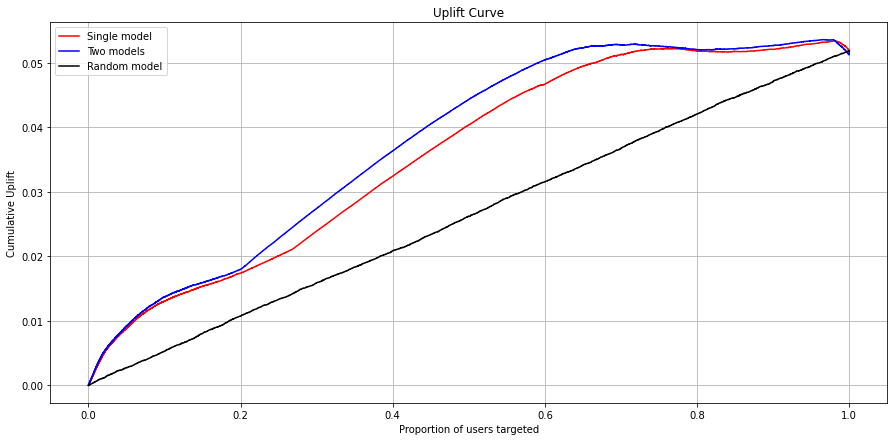

In [ ]:
#Plot the results
_, axes = plt.subplots(figsize=(15, 7))

instances=np.arange(0, 1, (1/len(y_valup)))

axes.set_title("Uplift Curve")
axes.set_xlabel("Proportion of users targeted")
axes.set_ylabel("Cumulative Uplift")
axes.grid(b=True)
axes.plot(instances, sm_gain['cum_gain2'].values, '-', color="r",label="Single model")
axes.plot(instances, tm_gain['cum_gain2'].values, '-', color="b",label="Two models")
axes.plot(instances, rnd_gain['cum_gain2'].values, '-', color="k",label="Random model")
axes.legend(loc="best")
#axes.set_xlim(0,0.5)
#axes.set_ylim(0,0.5)
plt.show()

In [ ]:
cut1 = int(len(tm_gain)*0.2)
cut2 = int(len(tm_gain)*0.6)

tm_gain_variables = tm_gain[['f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11']]

profile_1 = tm_gain_variables.iloc[:cut1]
profile_2 = tm_gain_variables.iloc[cut1+1:cut2]
profile_3 = tm_gain_variables.iloc[cut2+1:]

In [ ]:
import plotly.graph_objects as go

categories = profile_1.columns

#Plot 
fig = go.Figure()

fig.add_trace(go.Scatterpolar(
        r= profile_1.median().to_list(),
        theta=categories,
        fill='toself',
        name='Profile_1\'s area'
))

fig.add_trace(go.Scatterpolar(
        r= profile_2.median().to_list(),
        theta=categories,
        fill='toself',
        name='Profile_2\'s area'
))

fig.add_trace(go.Scatterpolar(
        r= profile_3.median().to_list(),
        theta=categories,
        fill='toself',
        name='Profile_3\'s area'
))

fig.show()